# Analyser bøker med en familie ordsekker

In [11]:
import json
import sqlite3
import requests
import pandas as pd
import dask
import pandas as pd
import dhlab.module_update as mu
mu.update('mods_meta')
import mods_meta as mm
import dhlab.nbtext as nb
import re
from IPython.display import Markdown, display
from collections import Counter
from dhlab.nbtokenizer import tokenize
import networkx as nx
import dhlab.graph_networkx_louvain as gnl
import datetime
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import json
mu.update('wordbank')

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\mods_meta.py`

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\wordbank.py`

In [12]:
from wordbank import word_paradigm_many

In [2]:
mu.css()

Set fontsizes for plots etc.

In [4]:
from nb_api_kollokasjon_konk import *

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\mods_meta.py`

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\collocations.py`

In [5]:
def corpus_def(urns):
    metadata = mm.metadata(urns)
    urns = [u for u in metadata if metadata[u] != []]
    return nb.frame({u:metadata[u] for u in urns})

In [6]:
def evaluate(temaer, corpus):
    theme_eval = nb.wordbag_eval(temaer,list(corpus.index))
    # legger til metadata
    result = theme_eval.join(titlestmnt(corpus))
    return result

In [25]:
def declensions(wordbagfamily, pos = None):
    """Set pos to subst, verb or adj for limiting the inflectional forms"""
    if isinstance(pos, list):
        res = {key: list(set([w for infl_set in word_paradigm_many(wordbagfamily[key]) for w in infl_set[2] if infl_set [1] in pos])) for key in wordbagfamily}
    elif isinstance( pos, str):
        res = {key: list(set([w for infl_set in word_paradigm_many(wordbagfamily[key]) for w in infl_set[2] if infl_set [1] == pos])) for key in wordbagfamily}
    else:
        res = {key: list(set([w for infl_set in word_paradigm_many(wordbagfamily[key]) for w in infl_set[2]])) for key in wordbagfamily}
    return res
    
    

In [7]:
titlestmnt = lambda x: pd.DataFrame(x[['245-1-0-a', '245-1-0-b','100-1- -a']])

# Lag familien 

Formen er en samling begreper med markører. De bør helst ikke noe til felles, for å lette tolkning av tellingen.

In [8]:
semantics = {
    'vehicles_': "kjøretøy biler bil sykkel fly tog buss trikk kollektivtransport lastebiler".split(),
    'roads_': "vei gate motorvei grusvei sti fortau".split(),
    'traffic_': "trafikk rushtid".split(),
    'occupants_': "fotgjengere gående".split(),
}

Fyll opp med bøyde former

In [33]:
enriched_semantics = declensions(semantics, pos='subs')

In [34]:
enriched_semantics

{'vehicles_': ['bussen',
  'trikkene',
  'lastebilene',
  'trikker',
  'lastebilen',
  'buss',
  'kjøretøyer',
  'sykkelen',
  'trikken',
  'kjøretøya',
  'flyet',
  'sykkel',
  'bilen',
  'tog',
  'flyen',
  'sykler',
  'flya',
  'syklene',
  'toga',
  'trikk',
  'bile',
  'lastebil',
  'togene',
  'lastebiler',
  'bussene',
  'flyene',
  'bil',
  'flyer',
  'kjøretøy',
  'bilene',
  'busser',
  'trikka',
  'fly',
  'kjøretøyet',
  'bila',
  'toget',
  'biler',
  'trikket',
  'kjøretøyene'],
 'roads_': ['stia',
  'gatene',
  'grusveien',
  'fortauet',
  'vei',
  'gate',
  'motorveier',
  'veiene',
  'stiene',
  'veier',
  'grusvei',
  'gata',
  'gaten',
  'veien',
  'motorvei',
  'motorveien',
  'stier',
  'grusveiene',
  'fortaua',
  'fortauer',
  'grusveier',
  'fortauene',
  'motorveiene',
  'gater',
  'stien',
  'stiet',
  'sti',
  'fortau'],
 'traffic_': ['trafikker',
  'rushtider',
  'rushtidene',
  'rushtid',
  'trafikk',
  'trafikkene',
  'rushtida',
  'rushtiden',
  'trafikke

# Definer et korpus ved å sample bøker med metadata

In [72]:
korpus1 = mm.metadata([x[1] for x in mm.meta_natbib(lang='nob', yearfrom=1970, yearto = 2010, limit = 5000)])

In [73]:
korpus2 = mm.metadata([x[1] for x in mm.meta_natbib(lang='nob', yearfrom=1930, yearto = 1970, limit = 5000)])

In [74]:
print(len(korpus2), len(korpus1))

4990 4997


# Ta en titt på korpus

In [75]:
korpus_1 = nb.frame(korpus1)

In [76]:
korpus_1

,100-1- -a,245-1-0-a,245-1-0-b,260- - -c,653- - -a,lang,year,245-1-3-a,245-1-3-b
2006082200049,"Berg, Ole",Hvor demokratisk? :,et essay om det norske politiske system,1978,"demokrati, demokrati-teori, folkestyre, norge,...",nob,1978,NaN,NaN
2006110600020,"Slaughter, Frank G.",Doktor Spencer Brade,NaN,1976,skjønnlitteratur/voksen,nob,1976,NaN,NaN
2006110600052,"Sandvik, Tore",Norsk panterett,NaN,cop. 1980,"eiendomsrett, juss, norsk, panterett, privatre...",nob,1980,NaN,NaN
2006110601018,"Lie, Haakon",- slik jeg ser det,NaN,1975,"1905, 1905-, 1945, 1945-1970, arbeiderbevegels...",nob,1975,NaN,NaN
2006110601020,"Messel, Gunnar",Begrav meg ikke i sand,NaN,1974,skjønnlitteratur/voksen,nob,1974,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2018062707187,NaN,NaN,NaN,2010,"autonomi, avhengighet, brukermedvirkning, e-sy...",nob,2010,NaN,NaN
2018071348023,NaN,NaN,NaN,1987,"borge, nordland, valberg, vestvågøy",nob,1987,NaN,NaN
2018071807166,NaN,NaN,NaN,2010,NaN,nob,2010,NaN,NaN
2018082007011,NaN,NaN,NaN,2010,NaN,nob,2010,NaN,NaN


In [77]:
korpus_2 = nb.frame(korpus2)

# Evaluate corpus against categories

In [78]:
korpus1_eval = evaluate(enriched_semantics, korpus_1)

In [79]:
korpus2_eval = evaluate(enriched_semantics, korpus_2)

In [68]:
def one(x):
    
    if isinstance(x, (float, int)) and x > 0:
        res = 1
    elif isinstance(x, (float, int)):
        res = 0
    else:
        res = x
    return res

In [69]:
def plotfig(a_plot, font_size = 18):
    fsize = plt.rcParams["font.size"]
    plt.rcParams["font.size"] = font_size
    ax = a_plot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    #plt.rcParams["font.size"] = fsize
    return


In [80]:
korpus1_eval

,roads_,vehicles_,traffic_,occupants_,snitt,245-1-0-a,245-1-0-b,100-1- -a
2011011003047,2095.0,129.0,61.0,1.0,571.50,Bergen byleksikon,NaN,"Hartvedt, Gunnar Hagen"
2014031306105,2007.0,80.0,43.0,1.0,532.75,Bergen byleksikon,NaN,"Hartvedt, Gunnar Hagen"
2009032600059,1193.0,128.0,2.0,0.0,330.75,Turguide til Kanariøyene :,50 flotte fotturer på Kanariøyene,"Løvland, Anita"
2010092103018,30.0,989.0,76.0,6.0,275.25,Veien til førerkortet :,"buss, lastebil, vogntog","Borch, Klaus"
2008011800080,394.0,442.0,26.0,4.0,216.50,Uten anger,NaN,"Clancy, Tom"
...,...,...,...,...,...,...,...,...
2009061104031,1.0,0.0,0.0,0.0,0.25,Mobbing kan stoppes! :,håndbok for skolen,"Høiby, Helle"
2013011706069,1.0,0.0,0.0,0.0,0.25,Turn og jazzgymnastikk,NaN,"Sørensen, Ragna"
2015042348025,1.0,0.0,0.0,0.0,0.25,NaN,NaN,NaN
2013012108106,1.0,0.0,0.0,0.0,0.25,NaN,NaN,NaN


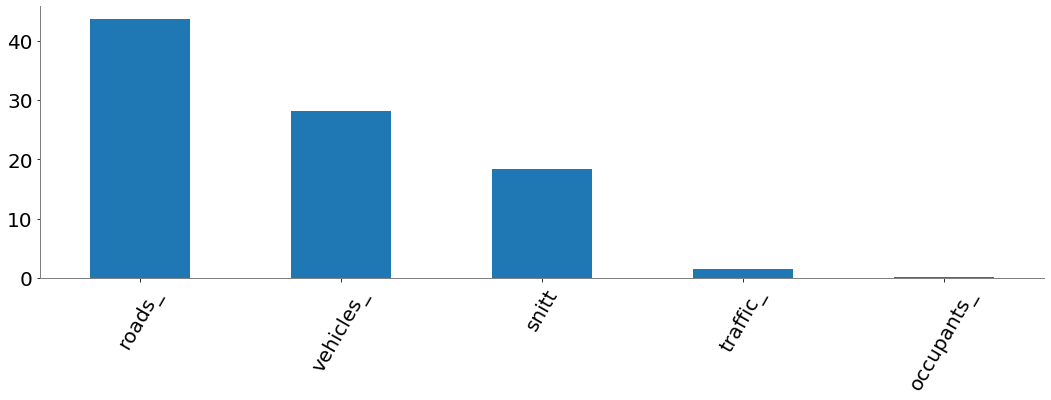

In [81]:
plotfig(korpus1_eval.mean().sort_values(ascending=False).plot(kind='bar', rot=60, figsize=(18,5)),
       font_size = 20)

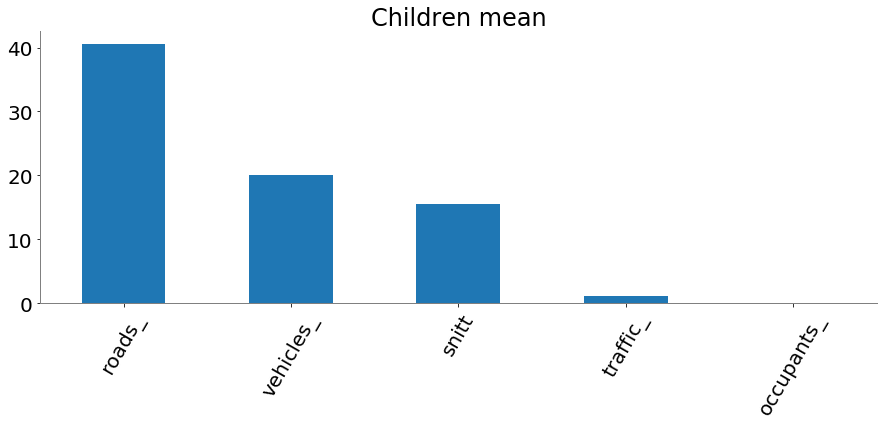

In [82]:
plotfig(korpus2_eval.mean().sort_values(ascending=False).plot(kind='bar', rot=60, figsize=(15,5), title="Children mean"))

In [83]:
def plot_together(A, B, aname = "A", bname = "B", rot = 60):
    df = pd.DataFrame()
    df[aname] = A
    df[bname] = B
    plotfig(df.sort_values(by=aname, ascending=False).plot(kind='bar', rot=60, figsize=(15,5), title="Comparison mean conditional"))
    return

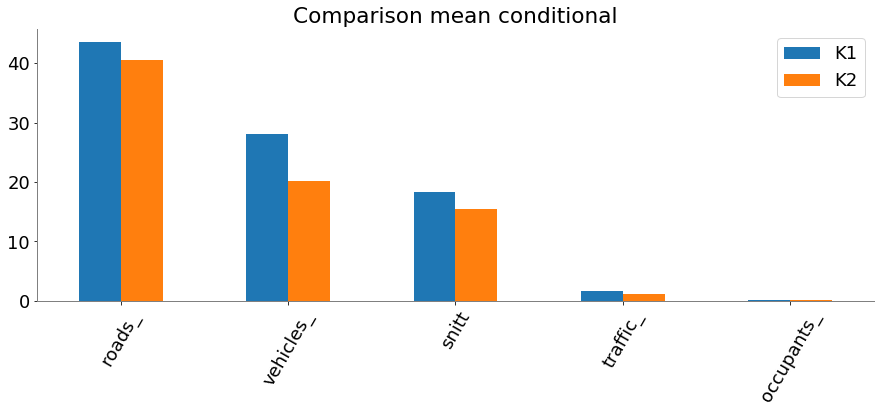

In [84]:
plot_together(korpus1_eval.mean(),
              korpus2_eval.mean(), aname = "K1", bname = "K2")

In [52]:
def cross(df, cols = None):
    if isinstance(cols, (list, object)):
        res = df[cols].transpose().dot(df[cols])
    else:
        res = df.transpose().dot(df)
    return res

In [53]:
def cosine_sims(df):
    """ similarity takes rows, so there must be transpose()"""
    cosines = pd.DataFrame(cosine_similarity(df.transpose()))
    cosines.columns = df.columns
    cosines.index = df.columns
    return cosines
     

In [54]:
def cosine_dists(df):
    """ similarity takes rows, so there must be transpose()"""
    cosines = pd.DataFrame(cosine_distances(df.transpose()))
    cosines.columns = df.columns
    cosines.index = df.columns
    return cosines
     

In [85]:
def show_info(weighted_frame):
    G = nx.from_pandas_adjacency(weighted_frame)
    display(Markdown('### Clusters'))
    gnl.show_graph(G)
    gnl.show_communities(G)
    #display(Markdown('### Central'))
    #display(nb.frame_sort(nb.frame([x for x in nb.central_betweenness_characters(G)])))